In [41]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch
from collections import Counter
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier


In [42]:
SAMPLE_RATE = 250  # Hz
CUTOFF_FREQ = 20.  # Hz high-pass cutoff
SAVE_FILE = "data/emg_handposes/sub-01/ses-01/emg_trial_data.pkl"

In [43]:
with open(SAVE_FILE, "rb") as f:
    trial_results = pickle.load(f)

print("Total number of trials:", len(trial_results))
print("Keys in the first trial:", trial_results[0].keys())

Total number of trials: 80
Keys in the first trial: dict_keys(['pose', 'round', 'cycle', 'samples', 'data'])


In [44]:
data_by_label = {}
for trial in trial_results:
    label = trial["pose"]
    if trial["data"] is not None and trial["data"].size > 0:
        data_by_label.setdefault(label, []).append(trial["data"])
        
for label, trials in data_by_label.items():
    print(f"{label}: {len(trials)} trials")
    print(f"  First trial shape: {trials[0].shape}")

Rest: 40 trials
  First trial shape: (8, 1050)
fist: 10 trials
  First trial shape: (8, 1050)
flat: 10 trials
  First trial shape: (8, 1050)
okay: 10 trials
  First trial shape: (8, 1050)
two: 10 trials
  First trial shape: (8, 1050)


Filter line noise and low frequency drifts

In [45]:
def comb_notch_filter(data, fs=SAMPLE_RATE, fundamental=60, n_harmonics=2, Q=30):
    """Sequentially applies notch filters to remove line noise at the fundamental and its harmonics."""
    filtered_data = np.copy(data)
    for i in range(1, n_harmonics + 1):
        freq = i * fundamental
        if freq < fs / 2:
            b, a = iirnotch(freq, Q, fs)
            filtered_data = filtfilt(b, a, filtered_data, axis=1)
    return filtered_data

def highpass_filter(data, cutoff, fs=SAMPLE_RATE, order=4):
    """Applies a Butterworth high-pass filter along axis=1."""
    nyquist = 0.5 * fs
    normalized_cutoff = cutoff / nyquist
    b, a = butter(order, normalized_cutoff, btype='high', analog=False)
    return filtfilt(b, a, data, axis=1)

In [46]:
for label, trials in data_by_label.items():
    for i in range(len(trials)):
        if trials[i].size > 0:
            filtered = comb_notch_filter(trials[i], fs=SAMPLE_RATE, fundamental=60, n_harmonics=2, Q=30)
            trials[i] = highpass_filter(filtered, cutoff=CUTOFF_FREQ, fs=SAMPLE_RATE, order=4)
print("Filtering complete.")

Filtering complete.


Choose channels we recorded from 

In [47]:
selected_channels = [1, 4, 7]

for label, trials in data_by_label.items():
    for i in range(len(trials)):
        trial_data = trials[i]
        trials[i] = trial_data[selected_channels, :]

# Verify the channel selection:
for label, trials in data_by_label.items():
    print(f"{label}: {len(trials)} trials")
    print(f"  First trial shape after channel selection: {trials[0].shape}")

Rest: 40 trials
  First trial shape after channel selection: (3, 1050)
fist: 10 trials
  First trial shape after channel selection: (3, 1050)
flat: 10 trials
  First trial shape after channel selection: (3, 1050)
okay: 10 trials
  First trial shape after channel selection: (3, 1050)
two: 10 trials
  First trial shape after channel selection: (3, 1050)


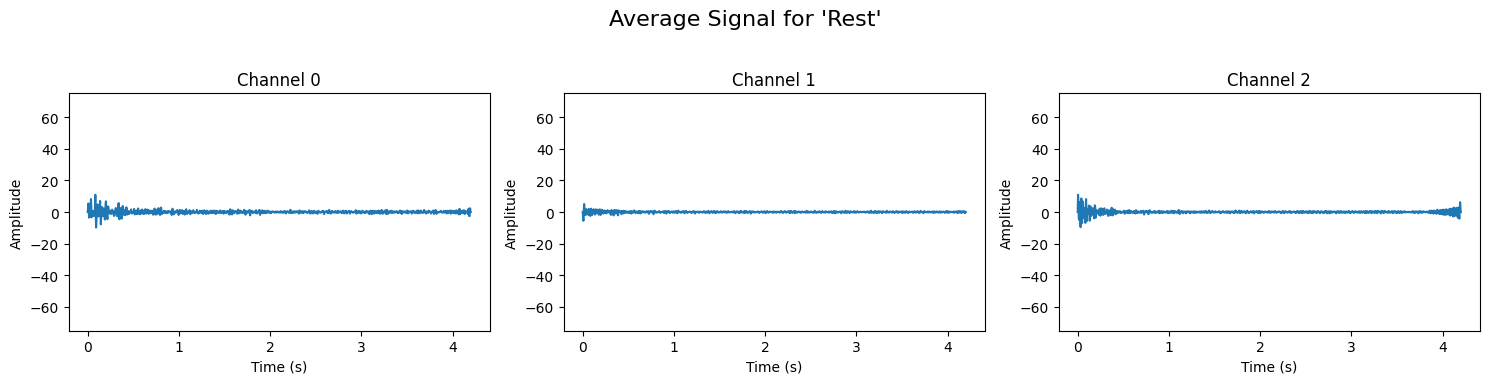

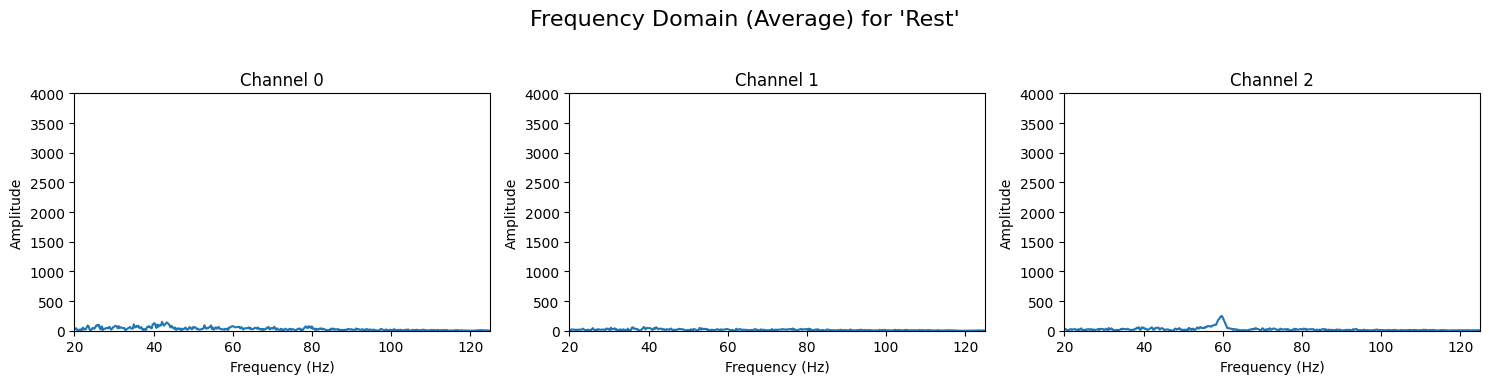

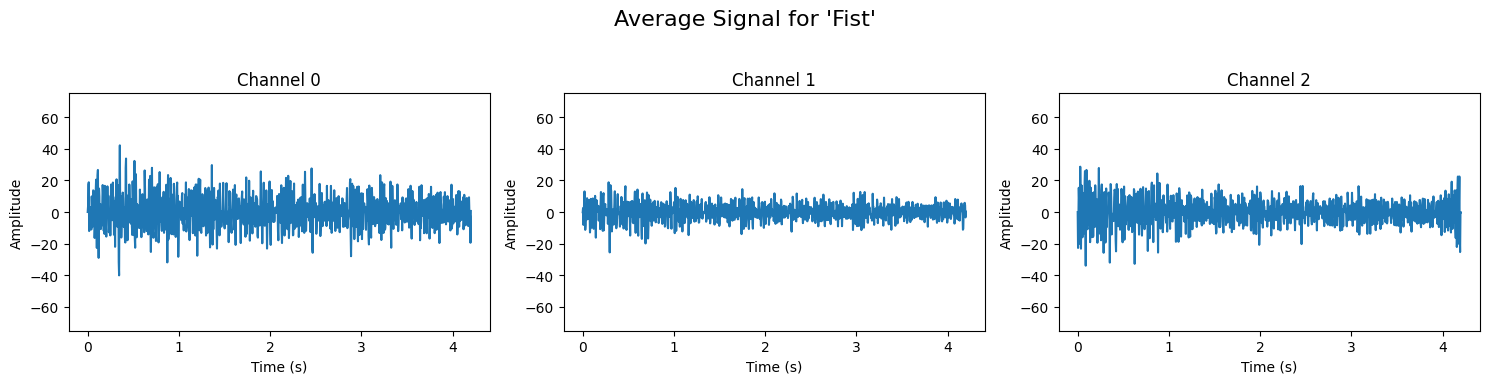

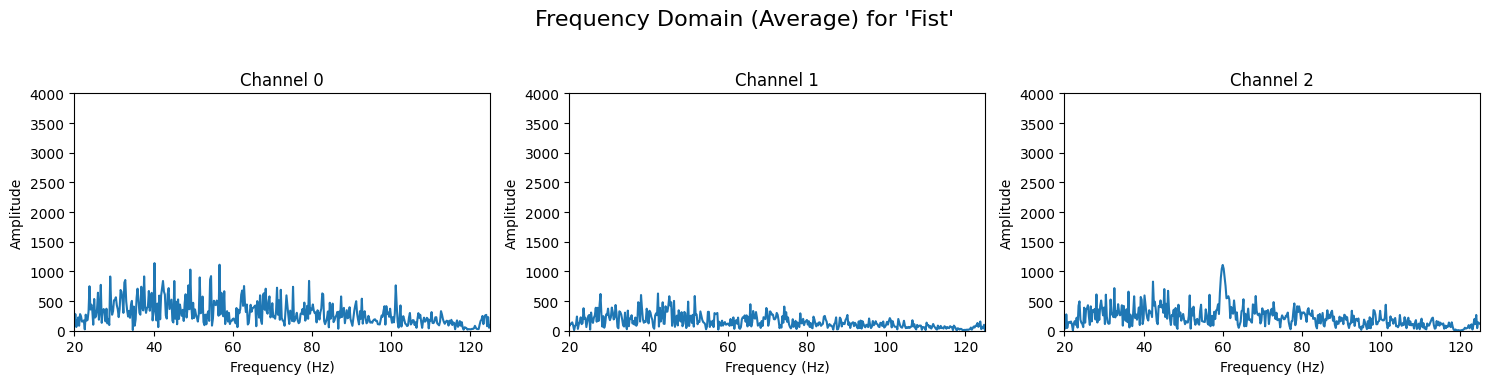

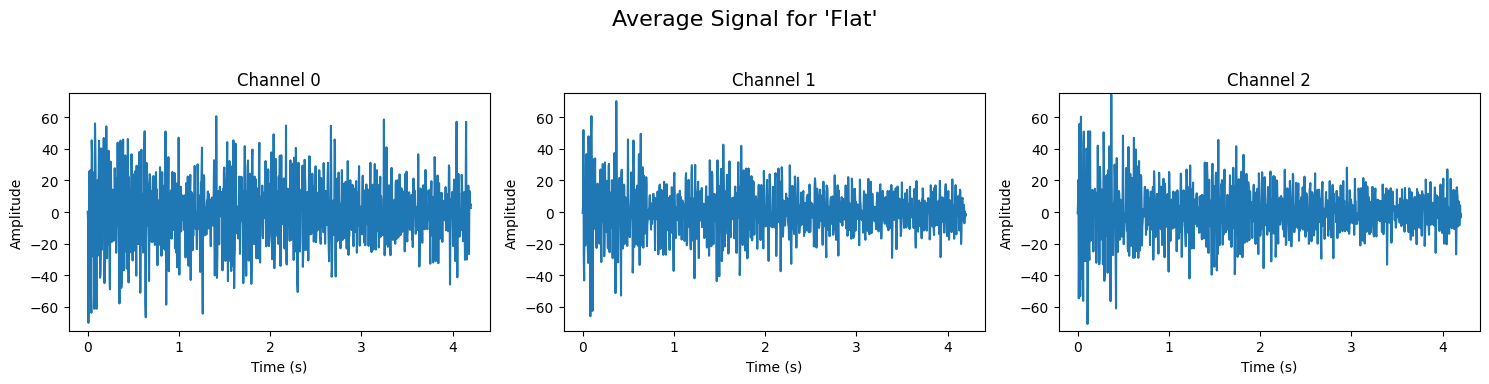

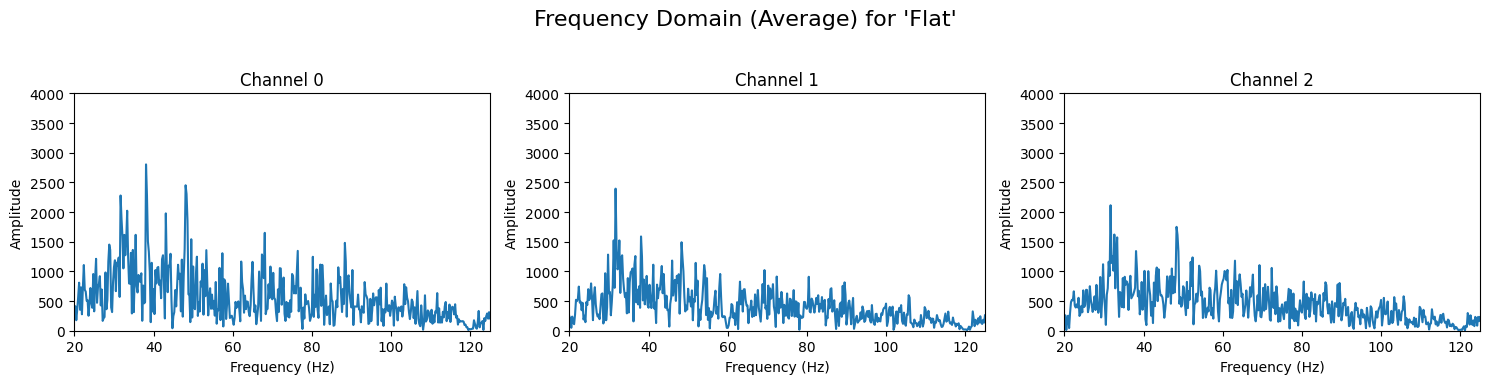

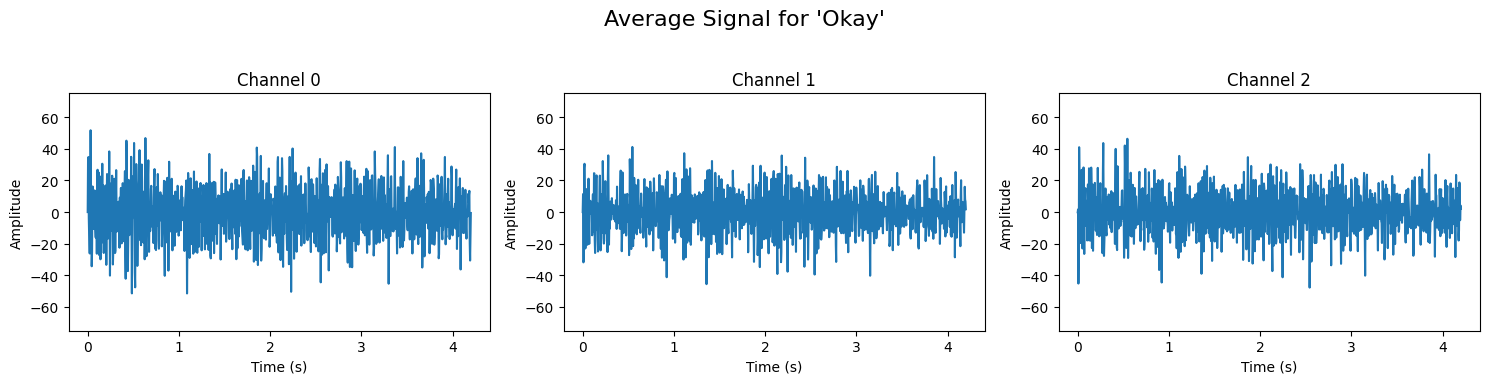

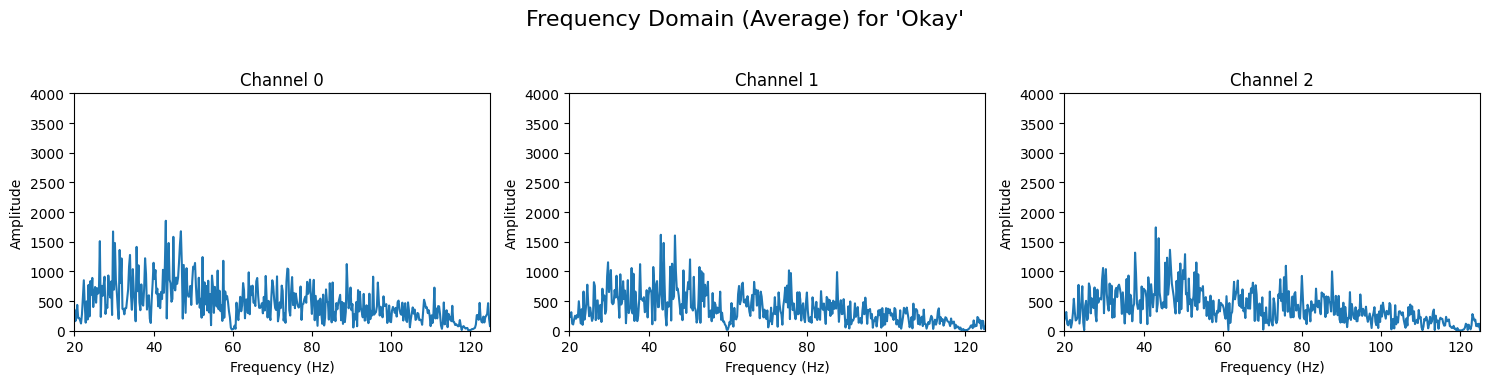

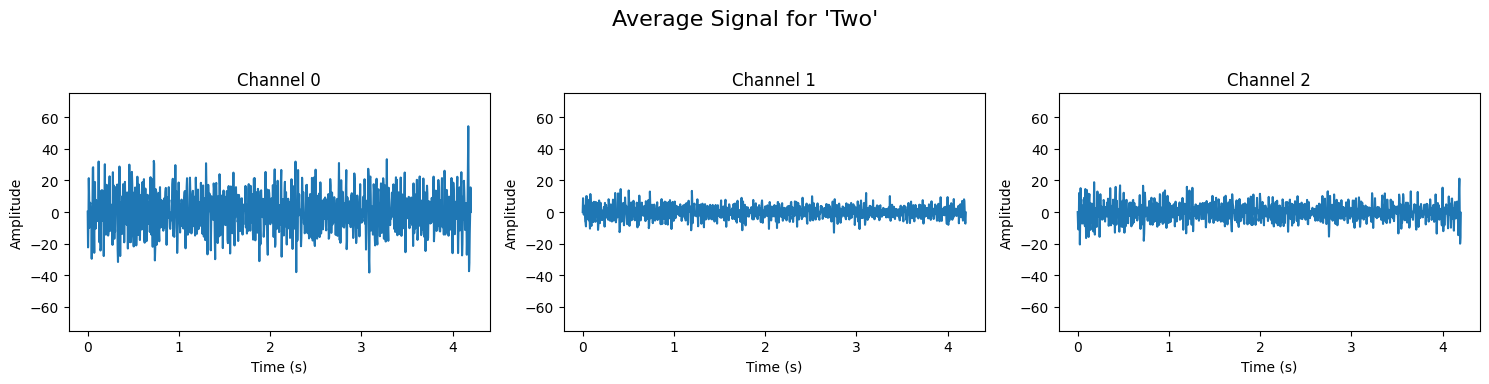

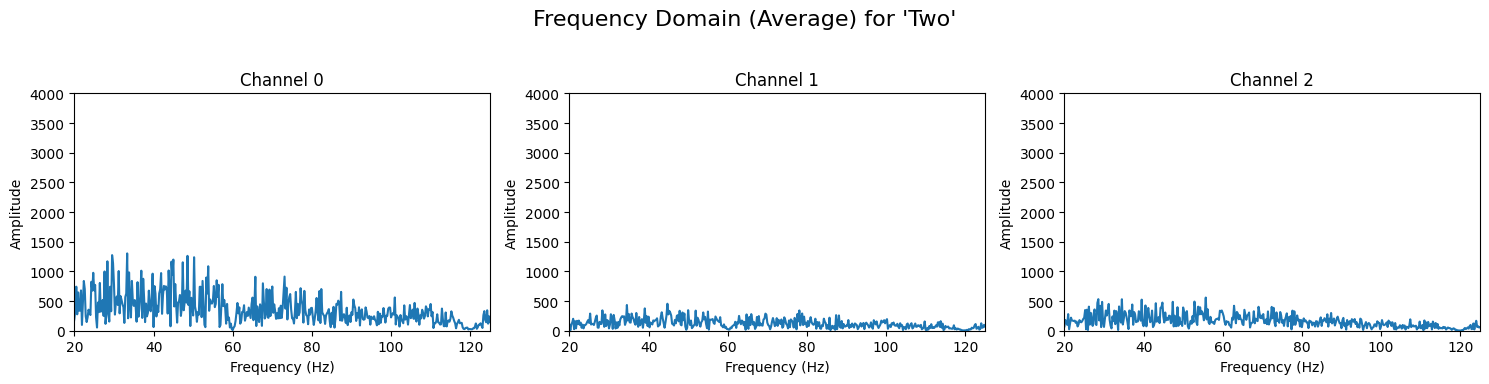

In [48]:
# Visualization: Plot time-domain and frequency-domain averages for each label
for label, trials in data_by_label.items():
    # Align trials to the minimum length in this label
    min_samples = min(trial.shape[1] for trial in trials)
    aligned_trials = np.array([trial[:, :min_samples] for trial in trials])
    
    # Time-domain average signal
    avg_signal = np.mean(aligned_trials, axis=0)
    time_axis = np.linspace(0, min_samples / SAMPLE_RATE, min_samples)
    
    fig, axs = plt.subplots(1, avg_signal.shape[0], figsize=(15, 4), sharex=True)
    fig.suptitle(f"Average Signal for '{label.capitalize()}'", fontsize=16)
    
    for ch in range(avg_signal.shape[0]):
        axs[ch].plot(time_axis, avg_signal[ch])
        axs[ch].set_title(f"Channel {ch}")
        axs[ch].set_xlabel("Time (s)")
        axs[ch].set_ylabel("Amplitude")
        axs[ch].set_ylim([-75, 75])  # Fixed y-axis limits for time domain
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    # Frequency-domain plot (remove DC offset first)
    # We modify 'avg_signal' in place, so if you want to preserve it, make a copy
    for ch in range(avg_signal.shape[0]):
        avg_signal[ch] -= np.mean(avg_signal[ch])
    freqs = np.fft.rfftfreq(min_samples, d=1/SAMPLE_RATE)
    fft_channels = [np.abs(np.fft.rfft(avg_signal[ch])) for ch in range(avg_signal.shape[0])]
    
    fig, axs = plt.subplots(1, avg_signal.shape[0], figsize=(15, 4), sharex=True)
    fig.suptitle(f"Frequency Domain (Average) for '{label.capitalize()}'", fontsize=16)
    
    for ch in range(avg_signal.shape[0]):
        axs[ch].plot(freqs, fft_channels[ch])
        axs[ch].set_title(f"Channel {ch}")
        axs[ch].set_xlabel("Frequency (Hz)")
        axs[ch].set_ylabel("Amplitude")
        axs[ch].set_xlim([20, 125])
        axs[ch].set_ylim([0, 4000])  # Fixed y-axis limits for frequency domain
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


Window the data into smaller windows for each original 4.2 second section of pose data.

I chose 0.42 since it divides the original sequence into 10 smaller windows but this can be changed to however we want. 

In [49]:
window_length_sec = 0.42
window_length = int( window_length_sec* SAMPLE_RATE)
overlap = 0
step = max(1, int(window_length * (1 - overlap)))  # step size

X_windowed, y_windowed = [], []
for label, trials in data_by_label.items():
    for trial in trials:
        if trial.size > 0:
            n_samples = trial.shape[1]
            for start in range(0, n_samples - window_length + 1, step):
                X_windowed.append(trial[:, start:start + window_length])
                y_windowed.append(label)


In [50]:
label_map = {"fist": 0, "flat": 1, "okay": 2, "two": 3, "Rest": 4}
y_windowed_int = [label_map[lbl] for lbl in y_windowed]
X_final = np.array(X_windowed)
y_final = np.array(y_windowed_int)
print("Final dataset shape:", X_final.shape)
print("Final labels shape:", y_final.shape)

Final dataset shape: (800, 3, 105)
Final labels shape: (800,)


In [51]:
print(Counter(y_final))

Counter({4: 400, 0: 100, 1: 100, 2: 100, 3: 100})


Since we end up recording rest for every single hand pose, we have 4 times the amount of rest classes in our data. In order to address this we can downsample the rest class. I did this by randomly selecting rest windows.

In [52]:
import random

# Example: Suppose you have X_list, y_list for your entire dataset
# X_list : list (or array) of feature vectors
# y_list : list of class labels (integers)

target_label = 4  # The class you want to downsample (e.g. 'rest')
# We'll downsample "rest" to match the smallest of the other classes

# 1) Group data by label
from collections import defaultdict
class_data = defaultdict(list)
for x, label in zip(X_final, y_final):
    class_data[label].append(x)

# 2) Find how many samples you want to keep from the target label.
#    For example, match the smallest class among the *other* labels.
min_other_class_size = min(len(samples)
                           for lbl, samples in class_data.items()
                           if lbl != target_label)

# 3) Build balanced dataset
X_balanced = []
y_balanced = []

for lbl, samples in class_data.items():
    if lbl == target_label:
        # Downsample the target class
        if len(samples) > min_other_class_size:
            chosen = random.sample(samples, min_other_class_size)
        else:
            chosen = samples
        X_balanced.extend(chosen)
        y_balanced.extend([lbl] * len(chosen))
    else:
        # Keep every sample from other classes
        X_balanced.extend(samples)
        y_balanced.extend([lbl] * len(samples))

# 4) Convert to NumPy arrays (if needed)
X_final = np.array(X_balanced)
y_final = np.array(y_balanced)



The datset is now balanced.

In [53]:
print(Counter(y_final))

Counter({4: 100, 0: 100, 1: 100, 2: 100, 3: 100})


I followed the feature extraction methods they used in this paper https://pmc.ncbi.nlm.nih.gov/articles/PMC4889824/. These seem to be quite common across EMG studies and more details about them can be found in the paper. 

In [54]:
def compute_features(signal):
#    rms = np.sqrt(np.mean(signal**2))
#    var = np.var(signal)
    mav = np.mean(np.abs(signal))
    ssc_count = sum(1 for i in range(1, len(signal) - 1)
                    if (signal[i] - signal[i-1]) * (signal[i+1] - signal[i]) < 0)
    zc_count = sum(1 for i in range(len(signal) - 1)
                   if (signal[i] > 0 and signal[i+1] < 0) or (signal[i] < 0 and signal[i+1] > 0))
    wl = np.sum(np.abs(np.diff(signal)))
    return np.array([mav, ssc_count, zc_count, wl])

all_features = []
for window in X_final:  # window.shape = (n_channels, window_length)
    window_features = []
    for ch_signal in window:
        window_features.extend(compute_features(ch_signal))
    all_features.append(window_features)
all_features = np.array(all_features)
print("Feature matrix shape:", all_features.shape)
print("Labels shape:", y_final.shape)

Feature matrix shape: (500, 12)
Labels shape: (500,)


In [55]:
feature_names = ["MAV", "SSC", "ZC", "WL"]
n_channels = X_final.shape[1]
feature_cols = [f"ch{ch}_{feat}" for ch in range(n_channels) for feat in feature_names]

df = pd.DataFrame(all_features, columns=feature_cols)
df["label_int"] = y_final
rev_label_map = {v: k for k, v in label_map.items()}
df["pose"] = df["label_int"].map(rev_label_map)
df


,ch0_MAV,ch0_SSC,ch0_ZC,ch0_WL,ch1_MAV,ch1_SSC,ch1_ZC,ch1_WL,ch2_MAV,ch2_SSC,ch2_ZC,ch2_WL,label_int,pose
0,3.319900,56.0,34.0,393.947740,1.941617,59.0,41.0,250.466731,2.093450,56.0,47.0,266.960299,4,Rest
1,0.678099,58.0,49.0,90.826637,0.659659,59.0,37.0,87.617162,1.282655,62.0,47.0,168.311974,4,Rest
2,3.812938,50.0,39.0,486.231552,2.721717,52.0,47.0,358.140550,9.531574,50.0,49.0,1360.099977,4,Rest
3,0.936843,44.0,36.0,104.294748,0.772143,56.0,44.0,109.282618,1.146665,60.0,51.0,163.479965,4,Rest
4,2.778492,50.0,43.0,376.238247,2.097964,60.0,47.0,270.922451,6.605145,51.0,50.0,929.548685,4,Rest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,32.315628,56.0,42.0,4132.574045,10.432252,55.0,42.0,1303.129247,10.426783,49.0,44.0,1393.427655,3,two
496,23.058024,51.0,37.0,2605.271376,8.551490,55.0,47.0,1198.894306,10.468876,51.0,47.0,1476.883689,3,two
497,27.811164,53.0,41.0,3427.742806,8.366707,62.0,45.0,1224.573744,8.881400,58.0,45.0,1215.299871,3,two
498,28.655887,50.0,43.0,3797.554845,8.565188,56.0,44.0,1222.684807,12.162149,56.0,41.0,1521.657677,3,two


In [56]:
excluded_labels = {}
keep_indices = [i for i, lbl in enumerate(y_final) if lbl not in excluded_labels]
features_filtered = all_features[keep_indices]
y_filtered = y_final[keep_indices]

X_train, X_test, y_train, y_test = train_test_split(features_filtered, y_filtered, 
                                                    test_size=0.2, random_state=42)

# Standardize features for the classifier
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

label_map = {0: "fist", 1: "flat", 2: "okay", 3: "two", 4:"rest"}
class_names = [label_map[i] for i in sorted(label_map.keys())]

param_grid_svm = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['rbf', 'linear']
}

param_grid_knn = {
    'n_neighbors': [1, 3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'p': [1, 2] 
}

In [57]:
svm_clf = SVC()
grid_search = GridSearchCV(
    estimator=svm_clf,
    param_grid=param_grid_svm,
    scoring='accuracy',  
    cv=5,                
    verbose=1,           
    n_jobs=-1            
)

grid_search.fit(X_train_scaled, y_train)

best_svm = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Hyperparameters: {'C': 10, 'gamma': 0.001, 'kernel': 'linear'}
Best CV Accuracy: 0.8725000000000002


In [58]:
y_pred_svm = best_svm.predict(X_test_scaled)
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred_svm, target_names=class_names))


Classification Report on Test Set:
              precision    recall  f1-score   support

        fist       0.93      0.93      0.93        14
        flat       0.83      0.50      0.62        10
        okay       0.82      0.96      0.88        24
         two       0.96      0.96      0.96        24
        rest       1.00      1.00      1.00        28

    accuracy                           0.92       100
   macro avg       0.91      0.87      0.88       100
weighted avg       0.92      0.92      0.91       100



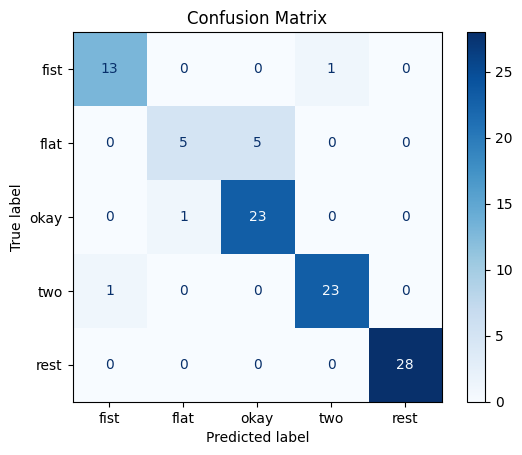

In [59]:
cm = confusion_matrix(y_test, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.title("Confusion Matrix")
plt.show()

In [60]:

knn_clf = KNeighborsClassifier()
grid_search_knn = GridSearchCV(
    estimator=knn_clf,
    param_grid=param_grid_knn,
    scoring='accuracy',  
    cv=5,                
    verbose=1,
    n_jobs=-1
)

grid_search_knn.fit(X_train_scaled, y_train)

best_knn = grid_search_knn.best_estimator_
print("Best Hyperparameters (kNN):", grid_search_knn.best_params_)
print("Best CV Accuracy (kNN):", grid_search_knn.best_score_)



Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Hyperparameters (kNN): {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Best CV Accuracy (kNN): 0.78


In [61]:
y_pred_knn = best_knn.predict(X_test_scaled)
print("\nClassification Report on Test Set (kNN):")
print(classification_report(y_test, y_pred_knn, target_names=class_names))


Classification Report on Test Set (kNN):
              precision    recall  f1-score   support

        fist       0.83      0.71      0.77        14
        flat       0.20      0.40      0.27        10
        okay       0.56      0.38      0.45        24
         two       0.92      0.92      0.92        24
        rest       1.00      1.00      1.00        28

    accuracy                           0.73       100
   macro avg       0.70      0.68      0.68       100
weighted avg       0.77      0.73      0.74       100



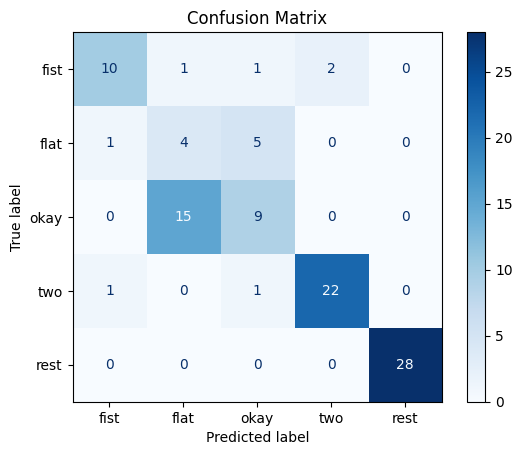

In [62]:
cm = confusion_matrix(y_test, y_pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.title("Confusion Matrix")
plt.show()

It seems that both SVM and kNN really struggle with the flat class. Maybe this just isn't a great class to include in our data, lets try classifying again but with flat removed. 

In [63]:
excluded_labels = {1}
keep_indices = [i for i, lbl in enumerate(y_final) if lbl not in excluded_labels]
features_filtered = all_features[keep_indices]
y_filtered = y_final[keep_indices]

X_train, X_test, y_train, y_test = train_test_split(features_filtered, y_filtered, 
                                                    test_size=0.2, random_state=42)


# Standardize features for the classifier
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

label_map = {0: "fist", 2: "okay", 3: "two", 4:"rest"}
class_names = [label_map[i] for i in sorted(label_map.keys())]

In [64]:
svm_clf = SVC()
grid_search = GridSearchCV(
    estimator=svm_clf,
    param_grid=param_grid_svm,
    scoring='accuracy',  
    cv=5,                
    verbose=1,           
    n_jobs=-1            
)

grid_search.fit(X_train_scaled, y_train)

best_svm = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Hyperparameters: {'C': 1, 'gamma': 0.001, 'kernel': 'linear'}
Best CV Accuracy: 0.975


In [65]:
y_pred_svm = best_svm.predict(X_test_scaled)
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred_svm, target_names=class_names))


Classification Report on Test Set:
              precision    recall  f1-score   support

        fist       0.89      0.94      0.92        18
        okay       1.00      0.89      0.94        18
         two       0.95      1.00      0.97        18
        rest       1.00      1.00      1.00        26

    accuracy                           0.96        80
   macro avg       0.96      0.96      0.96        80
weighted avg       0.96      0.96      0.96        80



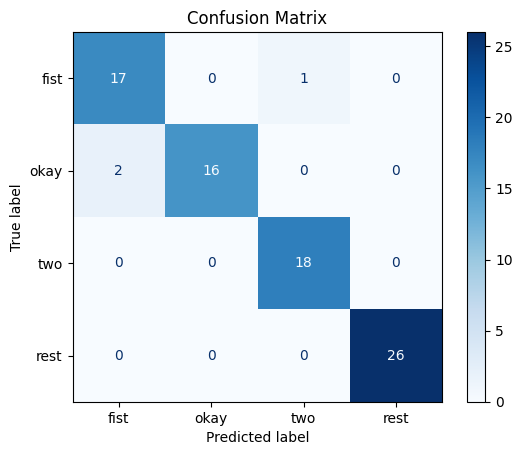

In [66]:
cm = confusion_matrix(y_test, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.title("Confusion Matrix")
plt.show()

In [67]:
knn_clf = KNeighborsClassifier()
grid_search_knn = GridSearchCV(
    estimator=knn_clf,
    param_grid=param_grid_knn,
    scoring='accuracy',  
    cv=5,               
    verbose=1,
    n_jobs=-1
)

grid_search_knn.fit(X_train_scaled, y_train)

# 8) Retrieve Best Model and Evaluate
best_knn = grid_search_knn.best_estimator_
print("Best Hyperparameters (kNN):", grid_search_knn.best_params_)
print("Best CV Accuracy (kNN):", grid_search_knn.best_score_)



Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Hyperparameters (kNN): {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
Best CV Accuracy (kNN): 0.91875


In [68]:
y_pred_knn = best_knn.predict(X_test_scaled)
print("\nClassification Report on Test Set (kNN):")
print(classification_report(y_test, y_pred_knn, target_names=class_names))


Classification Report on Test Set (kNN):
              precision    recall  f1-score   support

        fist       0.88      0.78      0.82        18
        okay       0.89      0.89      0.89        18
         two       0.90      1.00      0.95        18
        rest       1.00      1.00      1.00        26

    accuracy                           0.93        80
   macro avg       0.92      0.92      0.91        80
weighted avg       0.92      0.93      0.92        80



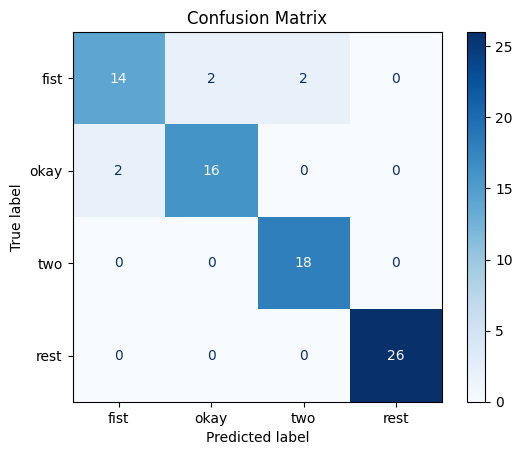

In [69]:
cm = confusion_matrix(y_test, y_pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.title("Confusion Matrix")
plt.show()

Much better results, SVM seems to be performing the best but we should prob try out more models and do a statistical test to make that decision. We do however want to keep in mind that we want a lightweigh low computationaly extensive model since we are going to have to do online classification and need to do other computations like filtering and feature extraction.